In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

In [177]:
import pandas as pd
import codecs
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'AppleGothic' #Macでmatplotlib日本語化
import matplotlib.finance as mpf
from matplotlib.dates import date2num

In [3]:
#snssns..set_styleset_sty ('whitegrid')
%matplotlib inline

pd.set_option("display.max_columns", 200) # 表示カラムの最大値
pd.set_option('display.max_rows', 20) # 表示行数の最大値
pd.set_option('display.max_colwidth', 30)
pd.set_option("display.float_format", '{:.2f}'.format) # 小数点以下の有効数字

# jupyterの幅を自動調整
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

### データ読み込み

In [141]:
with codecs.open("../01.data/cfd_result_2017.csv", "r", "Shift-JIS", "ignore") as file:
    data = pd.read_csv(file, header=2, parse_dates=True, dtype={'終値' : str} )
    # カラム名を設定
    data.columns = ['xxx', 'yyy', 
                'trading_day', 'aaa','price_start', 'price_high',  'price_low', 'price_close', 'bbb',
                'price_end_diff_N1', 'ccc', 'ddd', 'eee', 'fff']
    #  カラムを除外する
    data = data.drop(['xxx', 'yyy', 'aaa', 'bbb', 'ccc', 'ddd', 'eee', 'fff'], axis=1)
    data['trading_day'] = pd.to_datetime(data['trading_day'])

data = data.set_index('trading_day')

data['price_start'] = data['price_start'].str.replace(',', '').astype(int)
data['price_high'] = data['price_high'].str.replace(',', '').astype(int)
data['price_low'] = data['price_low'].str.replace(',', '').astype(int)
data['price_close'] = data['price_close'].str.replace(',', '').astype(int)

In [142]:
data.tail()

,price_start,price_high,price_low,price_close,price_end_diff_N1
trading_day,,,,,
2017-12-25,22984,23014,22921,22972,7.00
2017-12-26,22980,23010,22921,22986,14.00
2017-12-27,22925,23018,22909,22968,-18.00
2017-12-28,22966,23009,22774,22868,-100.00
2017-12-29,22892,22954,22770,22800,-68.00


In [143]:
data.dtypes

price_start            int64
price_high             int64
price_low              int64
price_close            int64
price_end_diff_N1    float64
dtype: object

### RCI
https://www.fxbroadnet.com/tech12.jsp  

RCIは、価格そのものを計算対象とせずに「時間」と「価格」それぞれに順位をつけ、両者にどれだけの相関関係があるのかを指標化したものです。

In [144]:
#  RCI
def RCI(seq, itv):
  def ord(seq, idx, itv):
    p = seq[idx]
    o = 1
    for i in range(itv - 1):
      if p < seq[i]:
        o += 1
    return o

  def d(seq, itv):
    sum = 0
    for i in range(itv - 1):
      sum += pow((i + 1) - ord(seq, i, itv), 2)
    return sum

  return (1 - 6 * d(seq, itv) / (itv * (itv ** 2 - 1))) * 100


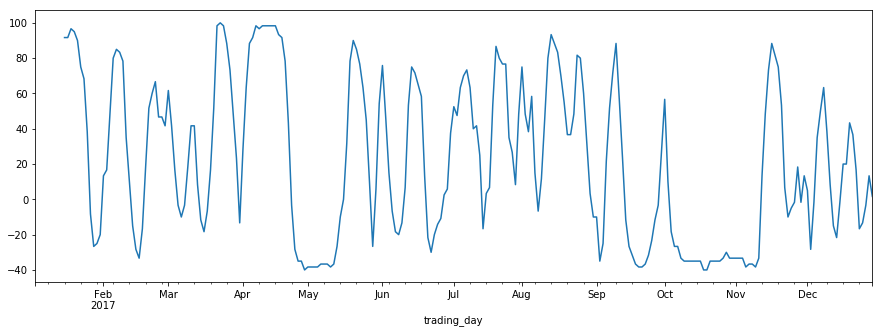

In [145]:
RCI_period = 9
RCI_list = []

for i in range(len(data)):
    if i- RCI_period + 1 >= 1 :
        # i - RCI_period + 1行目からi+1行目の終値を使ってRCI（期間：RCI_period）
        RCI_list.append( RCI( data[i - RCI_period + 1: i + 1 ].loc[:, 'price_close'],  RCI_period) )
         
    else :
        # 必要な期間の値がない場合はNANを代入
        RCI_list.append(np.nan)
        
data['RCI9'] = RCI_list
data['RCI9'].plot(figsize=(15,5))

### RSI
https://www.fxbroadnet.com/tech09.jsp  

RSI（The Relative Strength Index）は日本語で相対力指数と訳され、一定期間の値動きに対して上昇分の値動きが占める割合を算出し、価格の上昇の強さを数値化したチャートです。  
考案者は、テクニカル指標の父、米国のJ.W.ワイルダー。チャートの数値が一定の範囲（0～100など）で行ったり来たりする、いわゆるオシレーター指標の中でも、RSIは最もポピュラーなチャートの一つであり、FX取引でもよく使用されるチャートです。  

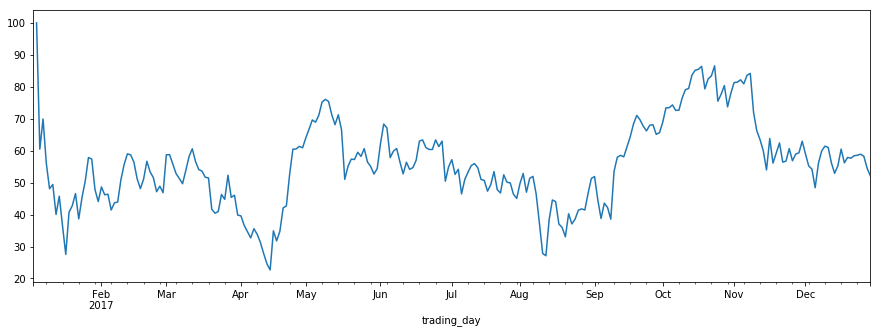

In [146]:
#RSI
RSI_period = 14
diff = data['price_close'].diff(1)
positive = diff.clip_lower(0).ewm(alpha=1/RSI_period).mean()
negative = diff.clip_upper(0).ewm(alpha=1/RSI_period).mean()
data['RSI'] = 100-100/(1-positive/negative)

data['RSI'].plot(figsize=(15,5))

## 移動平均
https://www.fxbroadnet.com/tech01.jsp  

移動平均線は、一定期間の平均価格を線でつなぎ、ジグザグした値動きのブレを慣らして価格トレンドの方向や強さを見るためのテクニカルチャートです。  
FXチャートに限らず、テクニカル分析の中で最もポピュラーで基本的な分析手法です。

移動平均には単純移動平均、加重移動平均、指数平滑移動平均など計算方法によって様々な種類がありますが、基本となる単純移動平均を例に説明します。

単純移動平均線（SMA,Simple Moving Average）は、計算の対象となる期間の複数の終値について平均値を算出し、期間をずらしながら線でつないで表示したものです。

たとえば20日移動平均（20SMA)であれば、本日を含めた過去20日間の終値を合計し、日数の20で割って平均した数値を１日ごとに計算して線でつなぎます。

In [147]:
data['MA25'] = data['price_close'].rolling(25).mean()
data['MA50'] = data['price_close'].rolling(50).mean()
data['MA75'] = data['price_close'].rolling(75).mean()

In [188]:
#data[['price_close', 'MA25', 'MA50', 'MA75' ]].plot(figsize=(15,5))

### ゴールデンクロス・デッドクロス

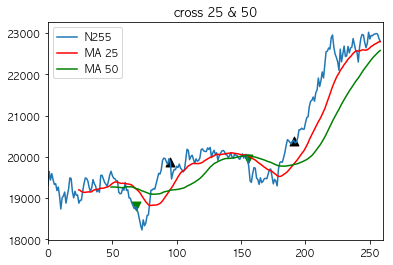

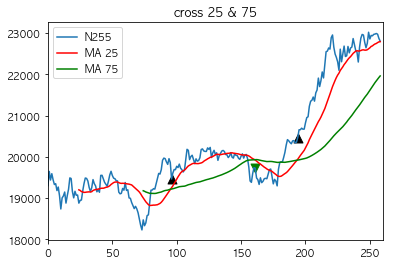

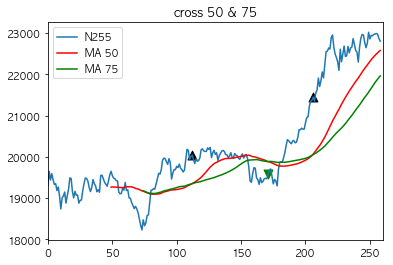

In [187]:
data = data.reset_index()
# [[短期, 長期], [短期, 長期] ・・・]
types = [[25, 50], [25, 75], [50, 75]]

for short_day, long_day in types:
 
    # 移動平均
    rolling_s  = data['price_close'].rolling(short_day).mean().fillna(0)
    rolling_l  = data['price_close'].rolling(long_day).mean().fillna(0)
 
    # 移動平均のクロス確認
    over_s_l  = rolling_s  > rolling_l
    golden = (over_s_l != over_s_l.shift(1)) & (over_s_l == True)
    dead   = (over_s_l != over_s_l.shift(1)) & (over_s_l == False)
 
    # 列 追加
    #   0：クロスなし
    #   1：ゴールデンクロス
    #  -1：デッドクロス
    col_name = 'cross_' + str(short_day) + '_' + str(long_day)
    data[col_name] = [x+y*-1 for x,y in zip(golden, dead)]
    data[col_name] = np.append(np.array([0] * (long_day+1)), data[col_name][long_day+1:])
    
    #
    # チャート描画
    #
    plt.plot(figsize = (18,5))
    plt.plot(range(len(data)), data['price_close'], label='N255')
    plt.plot(range(short_day-1, len(data)), rolling_s[short_day-1:], color='r', label='MA '+ str(short_day))
    plt.plot(range(long_day-1,  len(data)), rolling_l[long_day-1:],  color='g', label='MA '+ str(long_day))
    plt.legend(loc='upper left')
    plt.xlim(0, len(data)+1)
    
    #
    # ゴールデンクロス・デッドクロスのマークを描画する
    #
    crosses = data[data[col_name] != 0]
    
    golden_x = []
    golden_y = []
    golden_day = []
    dead_x = []
    dead_y = []
    dead_day = []
    
    for i in range(len(crosses)):
        if (crosses.iloc[i][col_name] == 1):
            golden_x.append(crosses.index[i])
            golden_y.append(crosses.iloc[i]['price_close'])
            golden_day.append(crosses.iloc[i]['trading_day'])
        else:
            dead_x.append(crosses.index[i])
            dead_y.append(crosses.iloc[i]['price_close'])
            dead_day.append(crosses.iloc[i]['trading_day'])
 
    plt.scatter(golden_x, golden_y, c='black', s=80, marker='^')
    plt.scatter(dead_x,   dead_y,   c='green', s=80, marker='v')
    
    """
    for i in range(len(golden_x)):
        plt.text(golden_x[i], golden_y[i]+500, '{0}-{1}'.format(int(golden_day[i][-5:-3]),int(golden_day[i][-2:])), ha = 'center', va = 'bottom')
    
    for i in range(len(dead_x)):
        plt.text(dead_x[i], dead_y[i]-500, '{0}-{1}'.format(int(dead_day[i][-5:-3]),int(dead_day[i][-2:])), ha = 'center', va = 'top', color='red')
 
    """
    plt.title('cross ' +  str(short_day) + ' & ' + str(long_day))

    
    plt.show()
    
# indexを戻す
data['trading_day'] = pd.to_datetime(data['trading_day'])
data = data.set_index('trading_day')

### ボリンジャーバンド
https://www.fxbroadnet.com/tech04.jsp  

ボリンジャーバンドは、相場の振れ幅（ボラティリティ）を一定期間の価格データから測定し、統計学的な観点から価格の変動範囲を予測してチャート上に表示するテクニカル指標です。  
ボリンジャーとは、開発者である米国人投資家のジョン・ボリンジャーの名を冠したものですが、現在も世界中で講演をするなど、ボリンジャーバンドを広める活動をしています。

In [165]:
#Bolinger Band
Bands_period = 25 #期間
Deviation = 1 #偏差の倍率

Base = data['price_close'].rolling(Bands_period).mean()
sigma = data['price_close'].rolling(Bands_period).std(ddof=0)
Upper = Base +sigma*Deviation
Lower = Base -sigma*Deviation
Upper2 = Base + 2*sigma*Deviation
Lower2 = Base -  2*sigma*Deviation

In [166]:
data['BLGR_sigma_p'] = Upper
data['BLGR_2sigma_p'] = Upper2
data['BLGR_sigma_m'] = Lower
data['BLGR_2sigma_m'] = Lower2

# 'BLGR_2sigma_p','BLGR_sigma_m','BLGR_2sigma_m',

In [185]:
#data[['price_close', 'MA25', 'BLGR_sigma_p', 'BLGR_2sigma_p', 'BLGR_sigma_m', 'BLGR_2sigma_m']].plot(figsize=(15, 6))

### ローソク足
https://qiita.com/toyolab/items/1b5d11b5d376bd542022  
https://qiita.com/kjybinp1105/items/be462b481b47b6f94b14  





In [168]:
def make_candle(candle_start, candle_end, data_candle):
    xdate = [x.date() for x in data_candle.index] #Timestamp -> datetime
    ohlc = np.vstack((date2num(xdate), data_candle.values.T)).T #datetime -> float
    
    return mpf.candlestick_ohlc(ax, ohlc, width=0.5, colorup='k', colordown='r')

In [169]:
# ローソク足を描画するする期間を指定
candle_start = '2017-07'
candle_end = '2017-12'

#　ローソク足を描画するデータを作成
data_candle = data[candle_start :  candle_end]
data_candle = data_candle[['price_start', 'price_high', 'price_low', 'price_close']]
data_candle.columns = ['open', 'high', 'low', 'close']

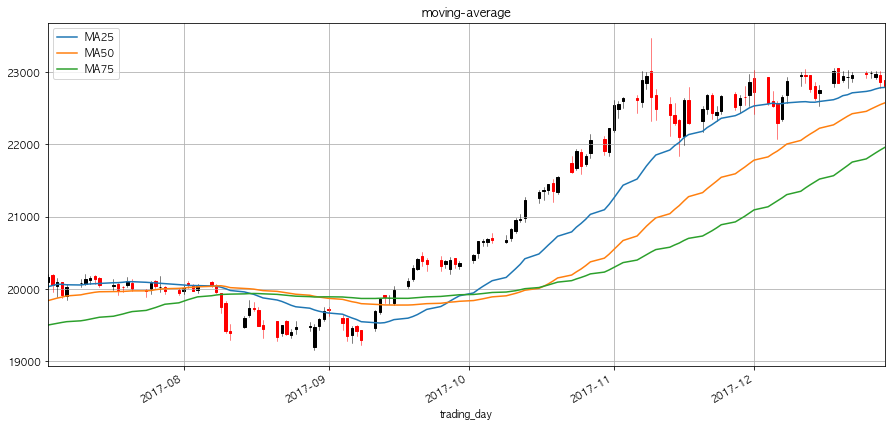

In [183]:
fig = plt.figure(figsize=(15, 7))
ax = plt.subplot()

# ローソク足を作成する関数 
make_candle(candle_start, candle_end, data_candle)

# 移動平均を描画する ------------------------------------------------------------------
data_candle = data[candle_start : candle_end ]
data_candle['MA25'].plot()
data_candle['MA50'].plot()
data_candle['MA75'].plot()
# -----------------------------------------------------------------------------------------

ax.grid() #グリッド表示
ax.set_xlim(data_candle.index[0].date(), data_candle.index[-1].date()) #x軸の範囲
fig.autofmt_xdate() #x軸のオートフォーマット
plt.legend()
plt.title('moving-average')

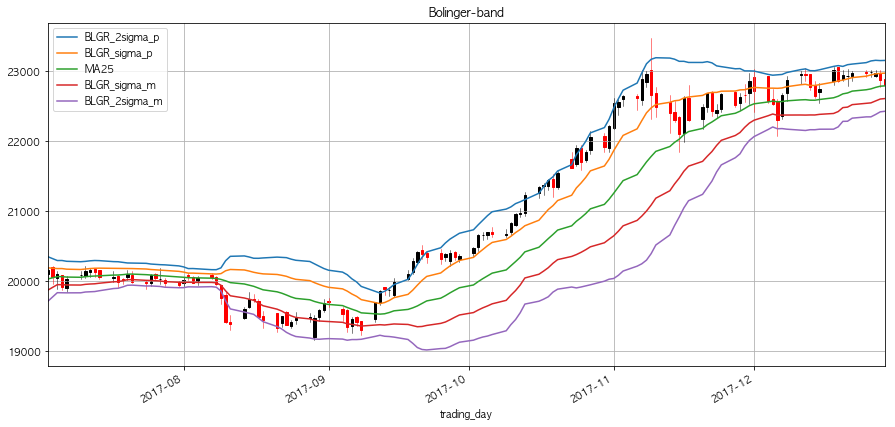

In [184]:
fig = plt.figure(figsize=(15, 7))
ax = plt.subplot()

# ローソク足を作成する関数 
make_candle(candle_start, candle_end, data_candle)

# 移動平均を描画する ------------------------------------------------------------------
data_candle = data[candle_start : candle_end ]
data_candle['BLGR_2sigma_p'].plot()
data_candle['BLGR_sigma_p'].plot()
data_candle['MA25'].plot()
data_candle['BLGR_sigma_m'].plot()
data_candle['BLGR_2sigma_m'].plot()

#data_candle[['price_close', 'MA25', 'BLGR_sigma_p', 'BLGR_2sigma_p', 'BLGR_sigma_m', 'BLGR_2sigma_m']].plot()
# -----------------------------------------------------------------------------------------

ax.grid() #グリッド表示
ax.set_xlim(data_candle.index[0].date(), data_candle.index[-1].date()) #x軸の範囲
fig.autofmt_xdate() #x軸のオートフォーマット
plt.legend()
plt.title('Bolinger-band')